# Brain Tumor Detection

### Part 1. **資料探索與清理**
   - 資料集基本資訊
   - 標註分析
   - 問題圖片識別
   - 資料清理

### Part2. **模型訓練流程**
   - 環境設置
   - 資料增強
   - Dataset 和 DataLoader
   - U-Net 模型
   - 訓練與驗證
   - 測試與視覺化


## Part 1: 資料探索與清理

1. 載入 Train/Valid/Test 的 COCO JSON 檔。
2. 分析並移除異常資料（無標註或重複標註的圖片）。
3. 儲存清理後的 JSON 檔。
4. 隨機顯示 3 張訓練集圖片及其遮罩以供檢查。


==================== Data Cleaning Report ====================

[TRAIN] Found issues:
  - Multi-annotated IDs: [1005]
  - No-annotation IDs: [1380]
  - Removed 2 images.
  - Saved cleaned to: .\train\_annotations.coco.cleaned.json

[VALID] No issues found. Saving copy for consistency.

[TEST] No issues found. Saving copy for consistency.

==================== Visualization (Train Samples) ====================


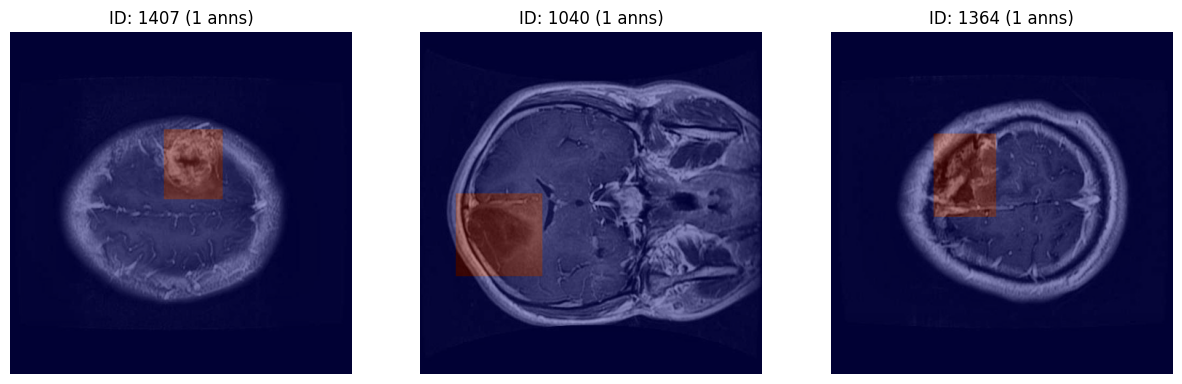

In [2]:
import json
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def clean_and_analyze_data():
    """
    分析並清理腦腫瘤分割資料集 (COCO 格式)。
    1. 識別無標註或多重標註的圖片。
    2. 移除異常圖片。
    3. 儲存清理後的 JSON 檔。
    4. 視覺化訓練集樣本。
    """
    
    datasets = ['train', 'valid', 'test']
    
    print(f"{'='*20} Data Cleaning Report {'='*20}")
    
    for split in datasets:
        json_path = os.path.join('.', split, '_annotations.coco.json')
        output_path = os.path.join('.', split, '_annotations.coco.cleaned.json')
        
        if not os.path.exists(json_path):
            print(f"[Warn] {json_path} not found.")
            continue
            
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
        images = data.get('images', [])
        annotations = data.get('annotations', [])
        
        # 分析標註數量：統計每張圖片對應的標註數
        img_ann_counts = defaultdict(int)
        for ann in annotations:
            img_ann_counts[ann['image_id']] += 1
            
        # 識別異常 ID
        ids_to_remove = set()
        
        # 情況 1：多重標註 (若邏輯上嚴格限制一張圖僅能有一個標註)
        multi_ann_ids = [img_id for img_id, count in img_ann_counts.items() if count > 1]
        ids_to_remove.update(multi_ann_ids)
        
        # 情況 2：無標註圖片
        all_img_ids = {img['id'] for img in images}
        annotated_img_ids = set(img_ann_counts.keys())
        no_ann_ids = all_img_ids - annotated_img_ids
        ids_to_remove.update(no_ann_ids)
        
        # 執行資料清理
        if ids_to_remove:
            print(f"\n[{split.upper()}] Found issues:")
            if multi_ann_ids: print(f"  - Multi-annotated IDs: {multi_ann_ids}")
            if no_ann_ids: print(f"  - No-annotation IDs: {list(no_ann_ids)}")
            
            # 過濾掉異常的圖片與標註
            new_images = [img for img in images if img['id'] not in ids_to_remove]
            new_anns = [ann for ann in annotations if ann['image_id'] not in ids_to_remove]
            
            data['images'] = new_images
            data['annotations'] = new_anns
            
            print(f"  - Removed {len(images) - len(new_images)} images.")
            print(f"  - Saved cleaned to: {output_path}")
            
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=4)
        else:
            print(f"\n[{split.upper()}] No issues found. Saving copy for consistency.")
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=4)

    print(f"\n{'='*20} Visualization (Train Samples) {'='*20}")
    
    # 從訓練集隨機抽取樣本進行視覺化檢查
    train_clean_path = os.path.join('.', 'train', '_annotations.coco.cleaned.json')
    if os.path.exists(train_clean_path):
        with open(train_clean_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        if not data['images']:
            print("No images to display.")
            return

        sample_imgs = random.sample(data['images'], min(3, len(data['images'])))
        
        plt.figure(figsize=(15, 5))
        for idx, img_info in enumerate(sample_imgs):
            img_path = os.path.join('.', 'train', img_info['file_name'])
            if not os.path.exists(img_path): continue
                
            # 讀取並轉換圖片色彩空間 (BGR -> RGB)
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # 建立遮罩 (Mask)
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            img_anns = [ann for ann in data['annotations'] if ann['image_id'] == img_info['id']]
            for ann in img_anns:
                if 'segmentation' in ann:
                     # 處理多邊形標註 (Polygon) 並填充至遮罩
                     for seg in ann['segmentation']:
                        poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                        cv2.fillPoly(mask, [poly], 1)
            
            # 繪圖
            plt.subplot(1, 3, idx+1)
            plt.imshow(img)
            plt.imshow(mask, alpha=0.4, cmap='jet') # 疊加半透明遮罩
            plt.title(f"ID: {img_info['id']} ({len(img_anns)} anns)")
            plt.axis('off')
        plt.show()

# 執行清理流程
clean_and_analyze_data()

## Part 2: 模型訓練與評估

整合同環境設置、資料增強、模型建構與訓練評估流程。



In [4]:
import os
import gc
import json
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# 系統設定
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# 設定計算裝置：優先使用 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

c:\Users\kslab\miniconda3\envs\DLproject\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [5]:
def get_transforms(image_size=256):
    """定義訓練集與驗證集的資料增強策略"""
    return {
        "train": A.Compose([
            A.Resize(image_size, image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussianBlur(p=0.2),
            A.ElasticTransform(alpha=1, sigma=50, p=0.2), # 彈性變形，增加模型強健性
            A.Normalize(),
            ToTensorV2()
        ]),
        "valid": A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(),
            ToTensorV2()
        ])
    }

# =============================================================================
# 自定義資料集類別：負責讀取影像與 COCO 格式的遮罩
# =============================================================================
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = Path(image_dir)
        self.transform = transform
        
        # 讀取標註檔
        try:
            with open(annotation_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
        except Exception:
            # 若清理後的檔案不存在，嘗試讀取原始檔案
            if 'cleaned' in annotation_file:
                alt_file = annotation_file.replace('.cleaned.json', '.json')
                with open(alt_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
            else: raise

        # 建立 ID 到圖片資訊與標註的映射
        self.images = {img['id']: img for img in data['images']}
        self.image_to_anns = defaultdict(list)
        for ann in data['annotations']:
            self.image_to_anns[ann['image_id']].append(ann)
        self.image_ids = list(self.images.keys())

    def __len__(self): 
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        info = self.images[image_id]
        img_path = self.image_dir / info['file_name']
        
        # 讀取圖片
        image = cv2.imread(str(img_path))
        if image is None: # 若圖片遺失，建立全黑圖片以防報錯
             image = np.zeros((info['height'], info['width'], 3), dtype=np.uint8)
        else:
             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
             
        # 建立遮罩 (將所有多邊形標註繪製到同一張遮罩上)
        mask = np.zeros((info['height'], info['width']), dtype=np.uint8)
        for ann in self.image_to_anns[image_id]:
            if 'segmentation' in ann:
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                    cv2.fillPoly(mask, [poly], 1)
        
        # 應用資料增強
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()
            
        return image, mask

def get_loaders(batch_size=8, num_workers=0):
    """建立 Train/Valid/Test 的 DataLoader"""
    transforms = get_transforms()
    loaders = {}
    for split in ['train', 'valid', 'test']:
        ann_file = f'./{split}/_annotations.coco.cleaned.json'
        if not os.path.exists(ann_file): 
            ann_file = f'./{split}/_annotations.coco.json'
            
        ds = BrainTumorDataset(
            image_dir=f'./{split}', 
            annotation_file=ann_file,
            transform=transforms['train'] if split == 'train' else transforms['valid']
        )
        
        loaders[split] = DataLoader(
            ds, 
            batch_size=batch_size if split != 'test' else 1, 
            shuffle=(split == 'train'), 
            num_workers=num_workers,
            pin_memory=True # 加速主機到 GPU 的資料傳輸
        )
    return loaders['train'], loaders['valid'], loaders['test']

In [6]:
def build_model():
    """建立 U-Net++ 模型，使用 ResNet34 作為編碼器 (Encoder)"""
    return smp.UnetPlusPlus(
        encoder_name="resnet34", 
        encoder_weights="imagenet", 
        in_channels=3, 
        classes=1
    )

def combined_loss(pred, target):
    """結合 BCE (二元交叉熵) 與 Dice Loss 的混合損失函數"""
    if target.dim() != pred.dim(): target = target.unsqueeze(1)
    target = target.float()
    
    # 1. BCE Loss
    bce = nn.BCEWithLogitsLoss()(pred, target)
    
    # 2. Dice Loss
    pred_sig = torch.sigmoid(pred)
    intersection = (pred_sig * target).sum()
    dice_score = (2. * intersection) / (pred_sig.sum() + target.sum() + 1e-7)
    dice_loss = 1 - dice_score
    
    return 0.5 * bce + 0.5 * dice_loss

def calculate_metrics(pred, target):
    """計算評估指標：Dice Score 與 IoU (Intersection over Union)"""
    pred_bin = (torch.sigmoid(pred) > 0.5).float()
    if target.dim() != pred.dim(): target = target.unsqueeze(1)
    target = target.float()
    
    intersection = (pred_bin * target).sum()
    dice = (2. * intersection) / (pred_bin.sum() + target.sum() + 1e-7)
    iou = intersection / (pred_bin.sum() + target.sum() - intersection + 1e-7)
    
    return dice.item(), iou.item()

def train_eval_loop(model, train_loader, valid_loader, epochs=10, patience=15):
    """訓練與驗證主迴圈，包含 Early Stopping 機制"""
    
    # 使用 Adam 優化器與學習率排程器
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience=5)
    scaler = GradScaler() # 用於混合精度訓練 (Mixed Precision)
    
    best_dice = 0
    patience_counter = 0
    
    print(f"Start training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # ------ 訓練階段 ------
        model.train()
        train_loss = 0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            with autocast(): # 啟用自動混合精度
                outputs = model(imgs)
                loss = combined_loss(outputs, masks)
            
            # 反向傳播與參數更新
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            
        # ------ 驗證階段 ------
        model.eval()
        val_dice_sum, val_iou_sum = 0, 0
        
        with torch.no_grad():
            for imgs, masks in tqdm(valid_loader, desc=f"Epoch {epoch+1} Valid", leave=False):
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                d, i = calculate_metrics(outputs, masks)
                val_dice_sum += d
                val_iou_sum += i
        
        avg_val_dice = val_dice_sum / len(valid_loader)
        avg_iou = val_iou_sum / len(valid_loader)
        
        print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, Valid Dice={avg_val_dice:.4f}, IoU={avg_iou:.4f}")
        
        scheduler.step(avg_val_dice)
        
        # 儲存最佳模型與 Early Stopping 檢查
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            torch.save(model.state_dict(), "best_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

In [7]:
try:
    print("Initializing Data Loaders...")
    train_loader, valid_loader, test_loader = get_loaders(batch_size=4, num_workers=0)
    
    print("Building Model...")
    model = build_model().to(device)
    
    print("Starting Training...")
    train_eval_loop(model, train_loader, valid_loader, epochs=20)
    print("Training finished. Best model saved as 'best_model.pth'.")
    
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Initializing Data Loaders...
Building Model...


c:\Users\kslab\miniconda3\envs\DLproject\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kslab\.cache\huggingface\hub\models--smp-hub--resnet34.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\kslab\AppData\Local\Temp\ipykernel_18528\3697630492.py:44: FutureWarning: `torch.cuda.amp.Gra

Starting Training...
Start training for 20 epochs...


Epoch 1 Train:   0%|          | 0/375 [00:00<?, ?it/s]C:\Users\kslab\AppData\Local\Temp\ipykernel_18528\3697630492.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # 啟用自動混合精度
c:\Users\kslab\miniconda3\envs\DLproject\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 